If running in a new environment, such as Google Colab, run this first.

In [ ]:
# !git clone https://github.com/zach401/acnportal.git
# !pip install acnportal/.

For this experiment, you will also need pandapower installed. Run the line of code below to install pandapower. We use pandapower 2.1.0 in this experiment.

In [ ]:
# !pip install pandapower==2.1.0

# ACN-Sim Experiments: Pandapower Co-Simulation
### by Sunash Sharma, Zachary Lee
#### Last updated: 11/06/2019

In this experiment, we use ACN-Sim in conjunction with pandapower to understand the effects of EV charging on the electrical grid. Specifically, we use outputs from simulations of the JPL ACN with different charging algorithms as inputs to a pandapower power flow at varying timesteps in a simple electrical grid. We experiment with adding EV charging to a grid already loaded with offices.

In a general sense, this tutorial demonstrates how ACN-Sim can be used to evaluate scheduled charging algorithms in the context of grid-level effects by feeding results from ACN-Sim Simulations into pandapower power flows.

In [18]:
import pandapower as pp
from pandapower import networks as pn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

import pytz
from datetime import datetime
from datetime import timedelta
from copy import deepcopy

from acnportal import acnsim
from acnportal import algorithms

import pickle as pkl
import json
from io import StringIO

## Running JPL ACN simulations

First let us run simulations of adaptive charging on the JPL ACN. We'll look at uncontrolled charging and least laxity first (LLF) algorithms. We run our simulations using EV data from May 7th, 2019 (the building data is from May 7th, 2004). May 7th was a weekday in both 2019 and 2004. The simulation parameters defined below are fed into simulation generating functions, the definitions of which may be found in the cell below. Note that `'balanced'` refers to a single-phase version of the JPL ACN, which we use for consistency with pandapower, which does not as of this writing allow for unbalanced 3-phase networks.

In [4]:
def balanced_acn(basic_evse=True, voltage=208, transformer_cap=195,
    network_type=acnsim.ChargingNetwork):
    """ Generates a simple ACN which has all the same station ids as
    the JPL ACN, but with all EVSEs connected to one transformer and
    balanced (each EVSE is connected to all 3 lines).
    """
    jpl_stations = acnsim.sites.jpl_acn(basic_evse=True).station_ids
    if basic_evse: 
        evse_type = 'BASIC'
    else:
        evse_type = 'AV'
    return acnsim.sites.simple_acn(jpl_stations,
                                 evse_type=evse_type,
                                 voltage=voltage,
                                 aggregate_cap=transformer_cap,
                                 network_type=network_type)
    
# TODO: This might go in a utils module.
# TODO: How do we handle api key for published experiments?
def run_sim(sim_algorithm=algorithms.BaseAlgorithm, 
            alg_kwargs={}, API_KEY='DEMO_TOKEN', 
            site='caltech', start_date=datetime(2019, 1, 1), 
            end_date=datetime(2019, 1, 2), period=1, verbose=False, 
            timezone='America/Los_Angeles', basic_evse=True):
    """Builds and runs a simulation with the input configuration details.
    
    Args:
        sim_algorithm (acnsim.algorithms.BaseAlgorithm constructor or callable): Algorithm function with which to run the simulation, default BaseAlgorithm.
        alg_kwargs (Dict[str, object]): Keyword args input to the algorithm constructor, default {}.
        API_KEY (str): API key for generating events, default 'DEMO_TOKEN'.
        site (str): Site on which to run simulation, default 'caltech'.
        start_date (datetime.datetime): Start datetime for simulation, default 01/01/2019 00:00.
        end_date (datetime.datetime): End datetime for simulation, default 01/02/2019 00:00.
        period (int): Simulation period in minutes, default 1.
        verbose (bool): Outputs events if True, default False.
        timezone (str): Timezone to localize start/end times, default 'America/Los_Angeles'.
        basic_evse (bool): If true, use a basic continuous EVSE model rather than the realistic discrete models.
    
    Returns:
        (acnsim.Simulator): Simulator object that has been run with the input algorithm.
    """
    # -- Config ------------------------------------------------------------------------------------------------------------
    timezone = pytz.timezone(timezone)
    start = timezone.localize(start_date)
    end = timezone.localize(end_date)
    # TODO: this should be a network property.
    voltage = 208  # volts
    # TODO: make this a kwarg?
    default_battery_power = 32 * voltage / 1000 # kW
    
    # -- Network -----------------------------------------------------------------------------------------------------------
    # TODO: site registration (like OpenAI Gym does)
    site_dict = {'caltech': acnsim.sites.caltech_acn, 
                 'jpl': acnsim.sites.jpl_acn, 
                 'office001': acnsim.sites.office001_acn,
                 'balanced': balanced_acn}
    try:
        site_fn = site_dict[site]
    except KeyError:
        # TODO: SiteNotFound error class
        raise KeyError("Site {0} not found".format(site))
    cn = site_fn(basic_evse=basic_evse, voltage=voltage)

    # -- Events ------------------------------------------------------------------------------------------------------------
    events = acnsim.acndata_events.generate_events(API_KEY, 'jpl', start, end, period, voltage, default_battery_power)
    
    # -- Algorithm ---------------------------------------------------------------------------------------------------------
    # TODO: is there a better way to handle offline case?
    if 'offline' in alg_kwargs and alg_kwargs['offline'] == True:
        alg_kwargs['events'] = events
    sch = sim_algorithm(**alg_kwargs)
    
    # -- Simulation --------------------------------------------------------------------------------------------------------
    sim = acnsim.Simulator(deepcopy(cn), sch, deepcopy(events), start, period=period, verbose=verbose)
    sim.run()
    return sim

In [5]:
# Define the static simulation parameters (start, end, site, period) as a config dict.
sim_year = 2019
sim_start = datetime(sim_year, 5, 7)
sim_end = datetime(sim_year, 5, 8)
sim_period = 5
sim_site = 'balanced'
config = {"start_date": sim_start,
          "end_date": sim_end,
          "period": sim_period,
          "site": sim_site}

# Simulate using uncontrolled charging.
sim_unc = run_sim(algorithms.UncontrolledCharging, **config)
# Simulate using the LLF algorithm.
sim_llf = run_sim(lambda: algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first),
                  **config)
sim_len = len(acnsim.aggregate_current(sim_unc))

/Users/sunash/Documents/schmidt/acnportal/acnportal/acnsim/simulator.py:182: UserWarning: Invalid schedule provided at iteration 86. Max violation is 22.499990000000025 A on Aggregate Current at time index 0.
  UserWarning)
/Users/sunash/Documents/schmidt/acnportal/acnportal/acnsim/simulator.py:182: UserWarning: Invalid schedule provided at iteration 87. Max violation is 22.499990000000025 A on Aggregate Current at time index 0.
  UserWarning)
/Users/sunash/Documents/schmidt/acnportal/acnportal/acnsim/simulator.py:182: UserWarning: Invalid schedule provided at iteration 88. Max violation is 86.49999000000003 A on Aggregate Current at time index 0.
  UserWarning)
/Users/sunash/Documents/schmidt/acnportal/acnportal/acnsim/simulator.py:182: UserWarning: Invalid schedule provided at iteration 89. Max violation is 246.49999000000003 A on Aggregate Current at time index 0.
  UserWarning)
/Users/sunash/Documents/schmidt/acnportal/acnportal/acnsim/simulator.py:182: UserWarning: Invalid schedul

Now that we have our simulation data, we next read in and format the building load data in a manner that may be used by panda power to conduct power flows. The building load data was taken from EERE. The load data is stored in `load_data_full`, a pandas DataFrame that can be input to pandapower as a time-varying load. Expand the below cell to see the computation used to process the load data.

In [11]:
# Load in Medium Office Building Data -----------------------------------------------------
# The year for which this data were gathered.
load_year = 2004
# File name for load data.
# TODO: Make sure this file is in the experiment directory.
load_file_name = "RefBldgMediumOfficeNew2004_7.1_5.0_3B_USA_CA_LOS_ANGELES.csv"
# Read in load data to a pandas DataFrame.
load_data_full = pd.read_csv(load_file_name, parse_dates=["Date/Time"])[["Date/Time", "Electricity:Facility [kW](Hourly)"]]
# Add the year for conversion to datetime objects.
load_data_full["Date/Time"] = ["{0} {1}".format(load_year, load_data_full["Date/Time"][i]) for i in range(len(load_data_full["Date/Time"]))]
# Convert date strings to 0-23 hour format.
def convert_23_hr(time_lst):
    """Helper function to convert an index of 1-24 hour datetimes to 0-23 hour datetimes.
    
    Args:
        time_lst (List[str]): List of 1-24 hour datetime strings to convert to 0-23 hour datetimes.
    Returns:
        List[datetime]: List of 0-23 hour datetimes
    """
    # First move the last element to the beginning, as 12/31 24:00 is really 01/01 00:00.
    time_lst = time_lst[-1:] + time_lst[:-1]
    time_lst[0] = time_lst[0][0:4] + " 01/01 00:00:00"
    for idx, time in enumerate(time_lst):
        try:
            date_time = datetime.strptime(time, '%Y %m/%d %H:%M:%S')
            time_lst[idx] = date_time
        except ValueError:
            time = time.replace(" 24", " 00")
            date_time = datetime.strptime(time, '%Y %m/%d %H:%M:%S')
            date_time += timedelta(days=1)
            time_lst[idx] = date_time
    return time_lst
load_data_full["Date/Time"] = convert_23_hr(load_data_full["Date/Time"].tolist())
# convert date strings to datetime objects
load_data_full["Date/Time"] = pd.to_datetime(load_data_full["Date/Time"])
# convert loads to MW
load_data_full["Electricity:Facility [MW](Hourly)"] = load_data_full["Electricity:Facility [kW](Hourly)"]/1000
# reindex based on time
load_data_full = load_data_full.set_index("Date/Time")
# Combine load and generation data in MW into one dataframe.
load_data_full.columns = ['Date/Time', 'Medium Office (MW)']
# TODO: check which of loads or pv has the last datetime stamp
load_data_full = load_data_full.fillna(method='ffill')
# Construct all relevant datetimes with sim_period increments for the load year.
base = load_data_full.index[0]
date_series = pd.date_range(base, load_data_full.index[-1],
                            freq="{0}min".format(sim_period))
# Reindex pv/load data with new, finer index and forward-fill NaN's. 
load_data_full = load_data_full.reindex(date_series).fillna(method='ffill')
load_start = sim_start.replace(year=load_year)
load_arr = load_data_full["Medium Office (MW)"][load_start:]

# We will cut off load after sim_len timesteps.
load_trunc = load_arr[:sim_len]

## Using Pandapower for Grid Evaluation

We can analyze the results of our simulations in the larger context of the electrical grid. Let's take the perspective of a system designer who wants to add EV charging to some sites without straining the rest of the electrical grid. Say the grid is configured like the Pandapower small branches-out test network, given at https://pandapower.readthedocs.io/en/v2.1.0/networks/test.html:
![image](pp_branches_out.png)
We start with a medium office building load on each of the four loads in the network. Pandapower power flows are static evaluations, so we will conduct a power flow at each timestep to understand how the grid behaves in time. First, some functions to help us construct the network, assign its loads, and run power flows. To avoid having to change the test case from the pandapower specification, we divide all loads by 2, which doesn't change relative load sizes and so is acceptable for the purposes of this study. To see the functions used to start the pandapower experiment, expand the cell below. We compile the simulation results into one DataFrame and then run power flows for 3 cases:

1. Only the building (medium office) is on each load; the scenario before EV chariging is added.

2. EV chariging is added but the charging is uncontrolled. For a given timestep, each load is then the sum of the builidng load and the aggregate load from uncontrolled charging calculable from our ACN-Sim simulations.

3. Uncontrolled charging is replaced by LLF scheduled EV charging in the system (the medium office load remains).

In [15]:
def create_network():
    """Creates a small branches-out test network with active and reactive power set to 0.
    
    Returns:
        pandapower.auxiliary.pandapowerNet: Output network.
    """
    small_network = pn.four_loads_with_branches_out()
    small_network.load["p_mw"] = 0
    small_network.load["q_mvar"] = 0
    return small_network

def assign_loads(network, load_val, loads=None):
    """In network, assigns load_val as the active power for the loads specified in loads, or to all loads if loads=None.
    
    Args:
        network (pandapower.auxiliary.pandapowerNet): Pandapower network on which to add loads.
        load_val (number): Load to assign to the p_mw (active power) field.
        loads (List[int]): Load indices for which to assign load_val as the active power. If None, assign load_val to all loads.
    
    Returns:
        None.
    """
    if loads is None:
        loads = network.load.index.tolist()
    network.load["p_mw"][loads] = load_val

def time_var_power_flow(load_results, n_timesteps, load_func):
    """Runs a power flow on the branches out network, for n_timesteps iterations, using load_func to generate loads to assign
    from the load_results DataFrame.
    
    Args:
        load_results (pd.DataFrame): a DataFrame with various loads/generations over time.
        n_timesteps (int): number of timesteps for which to run the power flow.
        load_func (pd.DataFrame, int -> number): a function that calculates a load from a DataFrame of loads and a timestep
    
    Returns:
        List[pandapower.auxiliary.pandapowerNet]: List of output networks (with power flow results) at each time step.
    """
    
    
    # Store output networks (with power flow results) in a list
    power_flows = []
    for i in range(0, n_timesteps, 1):
        load_val = load_func(load_results, i)/2
        curr_net = create_network()
        assign_loads(curr_net, load_val)
        # Save initial network state for deubbinging purposes.
        snapshot = curr_net
        # TODO: Once the experiment works, remove try-except block.
        try:
            pp.runpp(curr_net)
        except:
            print(i)
            diag_results = pp.diagnostic(snapshot, overload_scaling_factor=0.5)
            print(diag_results)
            input("Press any key to continue.")
        power_flows.append(curr_net)
    return power_flows

# DataFrame for all simulation and load data. Simulation data is the 
# aggregate current over time.
all_results = pd.DataFrame(
    columns=["Medium Office Load", "Uncontrolled Charging", "LLF Charging"])

all_results["Medium Office Load"] = load_trunc

# Set simulation data (converting amps to MW)
for column, sim in zip(all_results.columns[1:], [sim_unc, sim_llf]):
    # Convert ACN loads to MW.
    all_results[column] = acnsim.aggregate_current(sim) * 208 / 1000000

In [22]:
pf_loads = time_var_power_flow(
    all_results, sim_len, 
    lambda res, t: res["Medium Office Load"][t])
pf_loads_unc = time_var_power_flow(
    all_results, sim_len,
    lambda res, t: res["Medium Office Load"][t] + res["Uncontrolled Charging"][t])
pf_loads_llf = time_var_power_flow(
    all_results, sim_len,
    lambda res, t: res["Medium Office Load"][t] + res["LLF Charging"][t])

Let's see what the voltage on the last bus, farthest from the external grid (which would have the highest voltage difference from nominal out of all the buses), looks like for each of the 3 cases above. We plot in matplotlib

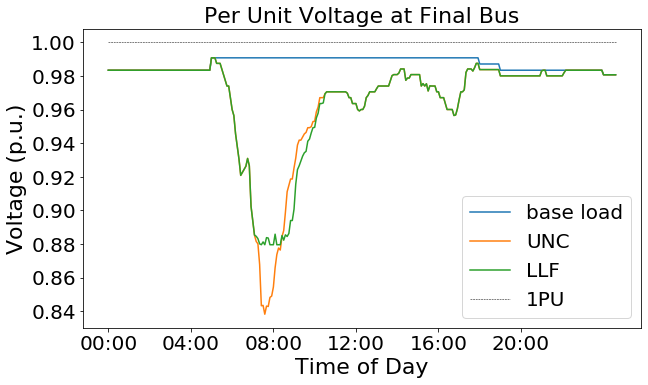

In [23]:
def generate_plt_datetimes(start, num_iterations, period):
    return [(start + timedelta(minutes=period*i)) for i in range(num_iterations)]
def strip_datetimes(datetime_lst, fstring='%H:%M'):
    return [datetime_elt.strftime(fstring) for datetime_elt in datetime_lst]
datetimes = generate_plt_datetimes(sim_start, sim_len, sim_period)
str_datetimes = [str(datetime_elt) for datetime_elt in datetimes]
plt.figure(figsize=(10, 5.5))
plt.plot(str_datetimes, [pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)],
         label="base load")
plt.plot(str_datetimes, [pf_loads_unc[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='UNC')
plt.plot(str_datetimes, [pf_loads_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='LLF')
plt.plot(str_datetimes, np.ones((sim_len,)), "black", linestyle='--', linewidth=0.5,
         label='1PU')
datetimes = strip_datetimes(datetimes)
plt.legend(loc='lower right', prop={'size':20})
plt.title("Per Unit Voltage at Final Bus", size=22)
plt.xlabel("Time of Day", size=22)
xtick_vals = ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00']
plt.xticks([datetimes.index(time) for time in xtick_vals], xtick_vals, fontsize=20)
plt.ylabel("Voltage (p.u.)", size=22)
plt.yticks(fontsize=20)
plt.show()

For the base load (blue curve), we can see that at worst, we are 2% below the nominal voltage. By adding uncontrolled EV charging, we have dropped drastically below the nominal voltage, over 16% lower. When we schedule our EV charging, we see we have reduced our voltage drop from nominal to only about 10%. Thus, we see the benefits of scheduled charging for grid performance metrics relative to uncontrolled EV charging. Indeed, scheduled EV charging allows us to do much more than just sorted scheduling algorithms; with grid health in mind, we may use objectives such as signal following or canceling to even further reduce grid strain from EV charging to more acceptable levels. This is an active area of research that makes heavy use of both ACN-Sim and grid simulators in manners similar to those demonstrated here.